In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


Run the script `image_dl.py` to download images of flowers and modern art pieces. Both datasets are manually pruned to remove images with excessive distracting objects or images with watermarks. The pruned datasets are placed in the data folder.

In [2]:
import pathlib
data_dir_X = './data/flowers'
data_dir_Y = './data/abstract'
data_dir_X = pathlib.Path(data_dir_X)
data_dir_Y = pathlib.Path(data_dir_Y)

list_ds_X = tf.data.Dataset.list_files(str(data_dir_X/'*.jpg'))
list_ds_Y = tf.data.Dataset.list_files(str(data_dir_Y/'*.jpg'))

Set up data preprocessing pipline. All images are resized to 286x286 and randomly to 256x256.

In [18]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 1000
BATCH_SIZE = 1
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image
def decode_img(input_img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(input_img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    return image
def process_path(file_path):
  # load the raw data from the file as a string
#   tf.print(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = tf.image.resize(img, [256, 256])
#   img = random_jitter(img)
  return img


In [19]:
dataset_X = list_ds_X.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).repeat().batch(BATCH_SIZE).prefetch(2)
dataset_Y = list_ds_Y.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).repeat().batch(BATCH_SIZE).prefetch(2)

In [20]:
test_X = dataset_X.take(10).repeat()
test_Y = dataset_Y.take(10).repeat()

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from trainer.config import config
from trainer.utils import dataset
from trainer.models import networks
from trainer import utils
from trainer import models
from trainer import callbacks

Unknown args: ['-f', '/home/jupyter/.local/share/jupyter/runtime/kernel-7448ecbb-dd3f-4512-b9c8-77d82ef1954f.json']
Parsed args: {'ds_name': 'cycle_gan/horse2zebra', 'startLRdecay': 100, 'disc_loss': 1, 'in_w': 256, 'is_test': False, 'buffer_size': 1000, 'ds_count': 1067, 'in_h': 256, 'm': True, 'generator_norm': 'instance', 'cycle_consistency_loss': 10, 'bs': 1, 'latent_z_dim': 8, 'job_dir': 'gs://duke-bme590-cz/ds-cyclegan/tmp/1575940463.9554846', 'model_dir': './trained_models', 'id_loss': 5, 'discriminator_norm': 'instance', 'ds_loss': 10, 'epochs': 10}


Create model, load pre-trained weights

In [8]:
dataset_count = 302
g_AB = networks.bicycle_generator(img_shape=(256, 256, 3), z_shape=(config.latent_z_dim,), norm=config.generator_norm, skip=False, z_in='all')
g_BA = networks.bicycle_generator(img_shape=(256, 256, 3), z_shape=(config.latent_z_dim,), norm=config.generator_norm, skip=False, z_in='all')
d_A = networks.create_discriminator(shape=(256, 256, 3), norm=config.discriminator_norm)
d_B = networks.create_discriminator(shape=(256, 256, 3), norm=config.discriminator_norm)

In [96]:
g_AB.load_weights('trained_models/g_AB.hdf5')
g_BA.load_weights('trained_models/g_BA.hdf5')
d_A.load_weights('trained_models/d_A.hdf5')
d_B.load_weights('trained_models/d_B.hdf5')

In [ ]:
Train the model. This step can be skiped if we're loading a pre-trained model

In [ ]:
LOG_DIR = 'trained_models/user/fabstract_resize256_1_3_0_2epoch155_lr'
MODEL_DIR = 'trained_models/user/models'

model = models.DSGAN(shape = (None, None, 3),
                     g_AB=g_AB,
                     g_BA=g_BA,
                     d_B=d_B,
                     d_A=d_A)

model.compile(lr_g=2e-4, lr_d=2e-4,
              d_loss='mse',
              g_loss = [
                 'mse', 'mse',
                 'mae', 'mae',
                 'mae', 'mae'
              ], loss_weights = [
                 1,  1,
                 3, 3,
                 0, 0,
                 2, 2
              ],
              metrics=[utils.ssim])

def scheduler(epoch):
    if epoch < 0:
        return 2e-4
    else:
        epochs_passed = epoch - 0
        decay_step = 2e-4 / (50 - 0)
        return 2e-4 - epochs_passed * decay_step

# Generate Callbacks
LRscheduler = callbacks.MultiLRScheduler(scheduler, training_models=[model.d_A, model.d_B, model.combined])
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, write_graph=True, update_freq='epoch')
start_tensorboard = callbacks.StartTensorBoard(LOG_DIR)
prog_bar = tf.keras.callbacks.ProgbarLogger(count_mode='steps', stateful_metrics=None)
log_code = callbacks.LogCode(LOG_DIR, './trainer')
copy_keras = callbacks.CopyKerasModel(MODEL_DIR, LOG_DIR)
saving = callbacks.MultiModelCheckpoint(MODEL_DIR + '/model.{epoch:02d}-{val_ssim:.10f}.hdf5',
                                        monitor='val_ssim', verbose=1, freq='epoch', mode='max', save_best_only=False,
                                        save_weights_only=True,
                                        multi_models=[('g_AB', g_AB), ('g_BA', g_BA), ('d_A', d_A), ('d_B', d_B)])
image_gen = callbacks.GenerateImages(g_AB, dataset_X, dataset_Y, LOG_DIR, interval=int(dataset_count/config.bs), z_shape=(config.latent_z_dim,))

# Fit the model
model.fit(dataset_X, dataset_Y,
    batch_size=config.bs,
    steps_per_epoch=(dataset_count // config.bs),
                     epochs=50,
                     validation_data=(test_X, test_Y),
                     validation_steps=10,
                     callbacks=[log_code, tensorboard, prog_bar, image_gen, saving,
                                copy_keras, start_tensorboard, LRscheduler])

Epoch 1/50
302/302 [==============================] - 455s 2s/step - d_loss: 0.1593 - d_acc: 78.9291 - g_loss: 1.8849 - adv_loss: 0.8151 - recon_loss: 0.1224 - id_loss: 0.1965 - ds_loss: -0.1199 - val_ssim: 0.0660

Epoch 00001: saving model to trained_models/user/models/model.01-0.0659974813.hdf5


 Starting Tensorboard at: trained_models/user/fabstract_resize256_1_3_0_2epoch161_nomeanLRdecay


Epoch 2/50
302/302 [==============================] - 458s 2s/step - d_loss: 0.1416 - d_acc: 81.9723 - g_loss: 1.7178 - adv_loss: 0.7960 - recon_loss: 0.1216 - id_loss: 0.2111 - lr: 2.0000e-04 - ds_loss: -0.1510 - val_ssim: 0.0660

Epoch 00002: saving model to trained_models/user/models/model.02-0.0791461766.hdf5
Epoch 3/50
302/302 [==============================] - 454s 2s/step - d_loss: 0.1249 - d_acc: 85.0799 - g_loss: 1.6874 - adv_loss: 0.8021 - recon_loss: 0.1143 - id_loss: 0.2122 - lr: 1.9600e-04 - ds_loss: -0.1506 - val_ssim: 0.0791

Epoch 00003: saving model to trained_models/user/models

In [74]:
def load_img(path_to_img):
  max_dim = 2048
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]
#   img = tf.cast(img, tf.float32)
  return img

In [78]:
import matplotlib.pyplot as plt
import numpy as np
def generate_images(model, test_input):
  z1 = tf.random.normal((1, 8))
  prediction1 = model([test_input, z1])
  z2 = tf.random.normal((1, 8))
  prediction2 = model([test_input, z2])  
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction1[0], prediction2[0]]
#   save_img_jpg(test_input[0], 'images/input/{}.jpg'.format(idx))
#   save_img_jpg(prediction[0], 'images/output/{}.jpg'.format(idx))
  title = ['Input Image', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

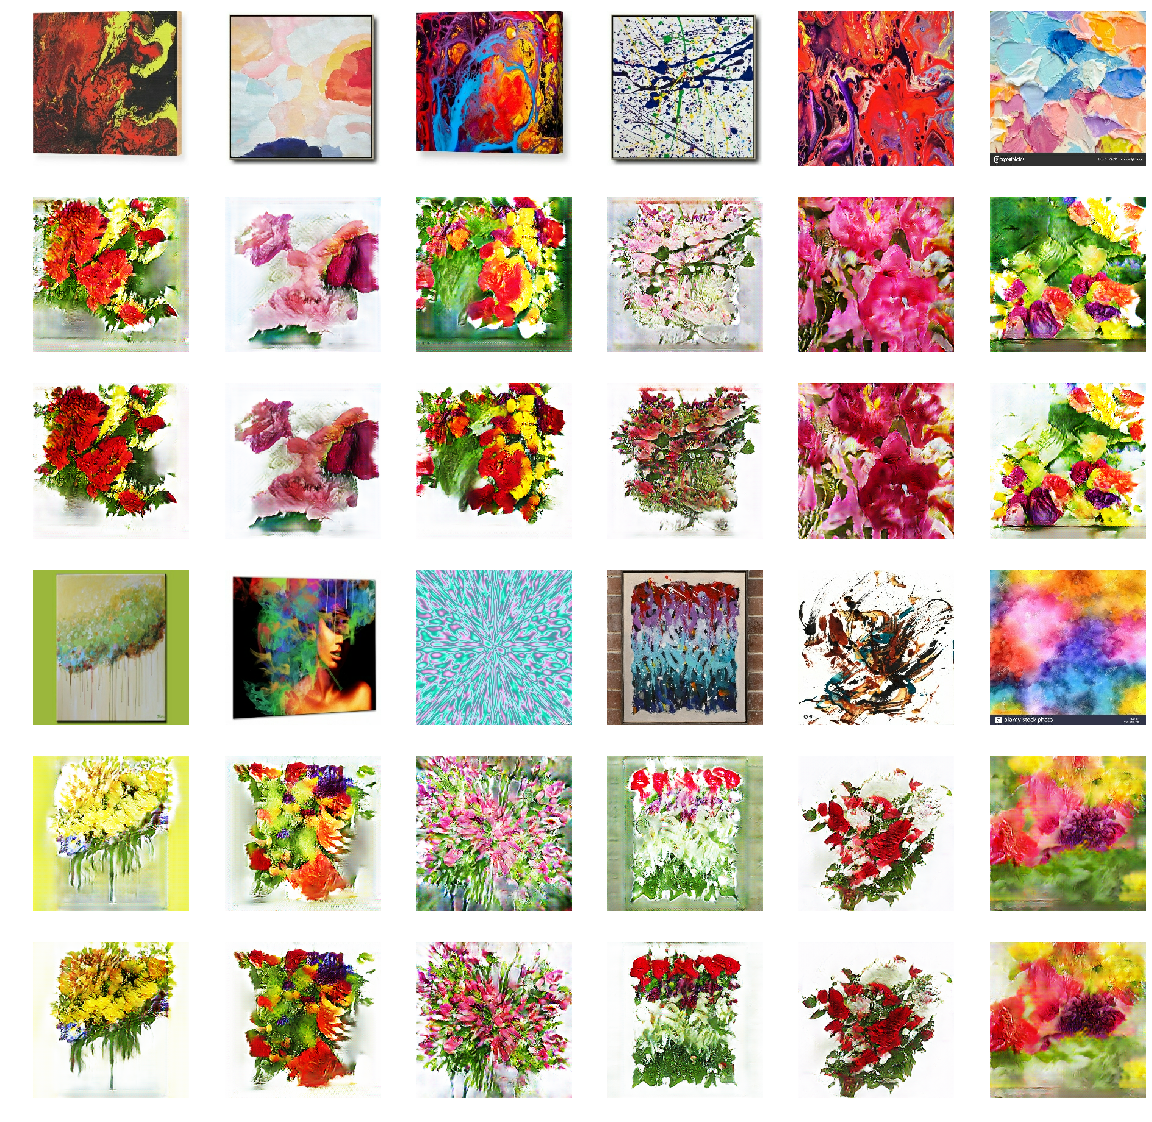

In [94]:
fig, axes = plt.subplots(6, 6, figsize=(20,20))
for j in range(12):
    inp = load_img('images/input/art{}.jpg'.format(j+1))
    z1 = tf.random.normal((1, 8), -.4, .2)
    prediction1 = g_BA([inp, z1])[0]
    z2 = tf.random.normal((1, 8), 1, 1)
    prediction2 = g_BA([inp, z2])[0]
    if j < 6:
        axes[0, j].imshow(inp[0])
        axes[1, j].imshow(prediction1)
        axes[2, j].imshow(prediction2)
    else:
        axes[3, j-6].imshow(inp[0])
        axes[4, j-6].imshow(prediction1)
        axes[5, j-6].imshow(prediction2)
for ax_arr in axes:
    for ax in ax_arr:
        ax.set_axis_off()


In [95]:
fig.savefig('images/output/combined.pdf')